In [1]:
from collections import defaultdict
import itertools
import multiprocessing as mp
import numpy as np
import pandas as pd
import pykonal
import scipy.sparse        # coo_matrix
import scipy.sparse.linalg # lsmr
import scipy.spatial       # Delaunay
import scipy.spatial
import sys

EARTH_RADIUS = 6371.
DTYPE_REAL   = np.float64

In [2]:
class Arguments(object):
    def __init__(self):
        pass
    
class VelocityModel(object):
    def __init__(self, grid, velocity):
        self.grid     = grid
        self.velocity = velocity

### Geometry functions

In [3]:
def geo2sph(arr):
    '''
    Map Geographical coordinates to spherical coordinates.
    '''
    geo = np.array(arr, dtype=DTYPE_REAL)
    sph = np.empty_like(geo)
    sph[...,0] = EARTH_RADIUS - geo[...,2]
    sph[...,1] = np.pi/2 - np.radians(geo[...,0])
    sph[...,2] = np.radians(geo[...,1])
    return (sph)


def sph2xyz(arr):
    '''
    Map spherical coordinates to Cartesian coordinates.
    '''
    sph = np.array(arr, dtype=DTYPE_REAL)
    xyz = np.empty_like(sph)
    xyz[...,0] = sph[...,0] * np.sin(sph[...,1]) * np.cos(sph[...,2])
    xyz[...,1] = sph[...,0] * np.sin(sph[...,1]) * np.sin(sph[...,2])
    xyz[...,2] = sph[...,0] * np.cos(sph[...,1])
    return (xyz)

In [4]:
def main():
    '''
    Main.
    '''
    argc                   = load_argc()
    params                 = load_params()
    df_events, df_arrivals = load_event_data(argc, params)
    df_stations            = load_network_data(argc)
    vmodel                 = load_initial_velocity_model(params)
    payload                = dict(
        events   = df_events,
        arrivals = df_arrivals,
        stations = df_stations,
        vmodel   = vmodel
    )
    # Iteratively invert data
    for i in range(params['niter']):
        vmodel = iterate_inversion(params, payload)
        return (vmodel)


def generate_projection_matrix(grid, ncell=300):
    '''
    Generate the matrix to project each rectilinear grid node to its
    host Voronoi cell.
    '''
    vcells = generate_voronoi_cells(grid, ncell)
    dist   = scipy.spatial.distance.cdist(
        sph2xyz(grid.nodes.reshape(-1, 3)), 
        sph2xyz(vcells)
    )
    colid = np.argmin(dist, axis=1)
    rowid = np.arange(np.prod(grid.nodes.shape[:-1]))
    
    Gp = scipy.sparse.coo_matrix(
        (np.ones(np.prod(grid.nodes.shape[:-1]),), (rowid, colid)),
        shape=(np.prod(grid.nodes.shape[:-1]), ncell)
    )
    return (vcells, Gp)


def generate_voronoi_cells(grid, ncell):
    '''
    Generate a random set of points representing the centers of Voronoi cells.
    '''
    delta = (grid.max_coords - grid.min_coords)
    return (np.random.rand(ncell, 3) * delta + grid.min_coords)

def find_ray_idx(ray, vcells):
    '''
    Determine the index of the Voronoi cell hosting each point on
    the ray path.
    '''
    dist = scipy.spatial.distance.cdist(sph2xyz(ray), sph2xyz(vcells))
    argmin = np.argmin(dist, axis=1)
    idxs, counts = np.unique(argmin, return_counts=True)
    return (idxs, counts)


def init_farfield(vmodel):
    '''
    Initialize the far-field EikonalSolver with the given velocity model.
    '''
    far_field                      = pykonal.EikonalSolver(coord_sys='spherical')
    far_field.vgrid.min_coords     = vmodel.grid.min_coords
    far_field.vgrid.node_intervals = vmodel.grid.node_intervals
    far_field.vgrid.npts           = vmodel.grid.npts
    far_field.vv                   = vmodel.velocity
    return (far_field)

def init_nearfield(far_field, origin):
    '''
    Initialize the near-field EikonalSolver.
    
    :param origin: Station location in spherical coordinates.
    :type origin: (float, float, float)
    
    :return: Near-field EikonalSolver
    :rtype: pykonal.EikonalSolver
    '''
    drho                            = far_field.vgrid.node_intervals[0] / 5
    near_field                      = pykonal.EikonalSolver(coord_sys='spherical')
    near_field.vgrid.min_coords     = drho, 0, 0
    near_field.vgrid.node_intervals = drho, np.pi/20, np.pi/20
    near_field.vgrid.npts           = 100, 21, 40
    near_field.transfer_velocity_from(far_field, origin)
    vvi = pykonal.LinearInterpolator3D(near_field.vgrid, near_field.vv)

    for it in range(near_field.pgrid.npts[1]):
        for ip in range(near_field.pgrid.npts[2]):
            idx = (0, it, ip)
            near_field.uu[idx]     = near_field.pgrid[idx + (0,)] / vvi(near_field.pgrid[idx])
            near_field.is_far[idx] = False
            near_field.close.push(*idx)
    return (near_field)



def iterate_inversion_dep(params, payload):
    '''
    Invert data and update *vmodel*.
    '''
    # Iterate over number of realizations.
    df_stations = payload['stations']
    for i in range(params['nreal']):
        vcells, G_proj = generate_projection_matrix(payload['vmodel'].grid, params['ncell'])
        df_obs         = sample_observed_data(params, payload)
        colidp   = []
        rowidp   = []
        nonzerop = []
        dobs     = []
        ridx     = 0
        sta_idx  = 0
        nsta     = len(df_obs.index.unique(level='station_id'))
        for station_id in df_obs.index.unique(level='station_id'):
            sta_idx += 1
            print(f'Processing station {station_id} ({sta_idx}/{nsta})...', end='\r')
            rho0, theta0, phi0 = geo2sph(
                df_stations.loc[station_id, ['lat', 'lon', 'depth']].values
            )
            far_field  = init_farfield(payload['vmodel'])
            near_field = init_nearfield(far_field, (rho0, theta0, phi0))
            near_field.solve()
            far_field.transfer_travel_times_from(near_field, (-rho0, theta0, phi0), set_alive=True)
            far_field.solve()
            tti = pykonal.LinearInterpolator3D(far_field.pgrid, far_field.uu)
            for event_id in df_obs.loc[station_id].index.unique():
                event = payload['events'].set_index('event_id').loc[event_id]
                print(f'Processing station {station_id} ({sta_idx}/{nsta}): event #{event_id}', end='\r')
                try:
                    rho_src, theta_src, phi_src = geo2sph(event[['lat', 'lon', 'depth']].values)
                    synthetic    = tti((rho_src, theta_src, phi_src))
                    residual     = df_obs.loc[(station_id, event_id), 'travel_time'] - synthetic
                    if abs(residual) > 3.0:
                        continue
                    ray          = far_field.trace_ray((rho_src, theta_src, phi_src))
                    idxs, counts = find_ray_idx(ray, vcells)
                    dobs.append(residual)
                    for iseg in range(len(idxs)):
                        colidp.append(idxs[iseg])
                        rowidp.append(ridx)
                        nonzerop.append(far_field._get_step_size() * counts[iseg])
                    ridx += 1
                except pykonal.OutOfBoundsError as err:
                    print(f'\nERROR :: {err}')
                    continue
            print('\n', end='\r')

        return (locals())

        G = scipy.sparse.coo_matrix((nonzerop, (rowidp, colidp)), shape=(ridx, params['ncell']))
        

        atol = 1e-3
        btol = 1e-4
        maxiter = 100
        conlim = 50
        damp = 1.0

        x = scipy.sparse.linalg.lsmr(G, dobs, damp, atol, btol, conlim, maxiter, show=False)
        x = x[0]
        vel = Gp * x
        return (vel)


def station_generator(payload):
    for station_id in payload['df_obs'].index.unique(level='station_id'):
        yield (station_id, payload)
    
    
def iterate_inversion(params, payload):
    '''
    Invert data and update *vmodel*.
    '''
    dv = [] 
    # Iterate over number of realizations.
    df_stations = payload['stations']
    for i in range(params['nreal']):
        print(f'Realization #{i+1}')
        vcells, G_proj = generate_projection_matrix(payload['vmodel'].grid, params['ncell'])
        df_obs         = sample_observed_data(params, payload)
        station_payload = dict(
            df_obs      = df_obs,
            df_stations = df_stations,
            vmodel      = payload['vmodel'],
            events      = payload['events'],
            vcells      = vcells
        )
                
        with mp.Pool(processes=params['nthreads']) as pool:
            pool_output = pool.map(process_station, station_generator(station_payload))

        dobs         = np.array(sum([out[0] for out in pool_output], []))
        col_idx_proj = np.array(sum([out[1] for out in pool_output], []))
        nseg         = np.array(sum([out[2] for out in pool_output], []))
        row_idx_proj = np.array([i for i in range(len(nseg)) for j in range(nseg[i])])
        nonzero_proj = np.array(sum([out[3] for out in pool_output], []))

        G = scipy.sparse.coo_matrix(
            (nonzero_proj, (row_idx_proj, col_idx_proj)), 
            shape=(len(nseg), params['ncell'])
        )
        

        atol = 1e-3
        btol = 1e-4
        maxiter = 100
        conlim = 50
        damp = 1.0

        x       = scipy.sparse.linalg.lsmr(G, dobs, damp, atol, btol, conlim, maxiter, show=False)[0]
        dv.append(G_proj * x)
    return (dv)


def process_station(args):
        station_id, payload = args
        print(f'\tProcessing station {station_id}')
        df_obs      = payload['df_obs']
        df_stations = payload['df_stations']
        vmodel      = payload['vmodel']
        events      = payload['events']
        vcells      = payload['vcells']
        colidp      = []
        nsegs       = []
        nonzerop    = []
        dobs        = []
        rho0, theta0, phi0 = geo2sph(
            df_stations.loc[station_id, ['lat', 'lon', 'depth']].values
        )
        far_field  = init_farfield(payload['vmodel'])
        near_field = init_nearfield(far_field, (rho0, theta0, phi0))
        near_field.solve()
        far_field.transfer_travel_times_from(near_field, (-rho0, theta0, phi0), set_alive=True)
        far_field.solve()
        tti = pykonal.LinearInterpolator3D(far_field.pgrid, far_field.uu)
        for event_id in df_obs.loc[station_id].index.unique():
            event = payload['events'].set_index('event_id').loc[event_id]
            try:
                rho_src, theta_src, phi_src = geo2sph(event[['lat', 'lon', 'depth']].values)
                synthetic    = tti((rho_src, theta_src, phi_src))
                residual     = df_obs.loc[(station_id, event_id), 'travel_time'] - synthetic
                if abs(residual) > 3.0:
                    continue
                ray          = far_field.trace_ray((rho_src, theta_src, phi_src))
                idxs, counts = find_ray_idx(ray, vcells)
                nseg = len(idxs)
                nsegs.append(nseg)
                dobs.append(residual)
                for iseg in range(nseg):
                    colidp.append(idxs[iseg])
                    nonzerop.append(far_field._get_step_size() * counts[iseg])
            except pykonal.OutOfBoundsError as err:
                continue
        return (dobs, colidp, nsegs, nonzerop)
        


def load_argc():
    '''
    Return command line arguments.
    '''
    argc              = Arguments()
    argc.event_file   = 'events.h5'
    argc.network_file = 'network.h5'
    return (argc)


def load_params():
    '''
    Return parameter file parameters.
    '''
    params = dict(
        latmin   = 32.4,
        lonmin   = -120.1,
        depmin   = -3,
        nlat     = 105,
        nlon     = 127,
        nrad     = 34,
        dlat     = 0.04,
        dlon     = 0.04,
        drad     = 1.0,
        damp     = 0.0,
        datafile = 'scecdc2018.nc',
        phase    = 'P',
        nsamp    = 500, # Number of observations (arrivals) to sample.
        ncell    = 600,  # Number of Voronoi cells per realization.
        nreal    = 5,    # Number of realizations per iteration.
        niter    = 1,    # Number of iterations.
        nthreads = 8
    )
    return (params)


def load_event_data(argc, params):
    '''
    Read and return *events* and *arrivals* tables from pandas.HDFStore.
    '''
    with pd.HDFStore(argc.event_file) as store:
        df_events   = store['events']
        df_arrivals = store['arrivals']
    df_arrivals['station_id'] = df_arrivals['net'] + '.' + df_arrivals['sta']
    df_arrivals = df_arrivals.drop(
        columns=['net', 'sta']
    ).set_index(
        'phase'
    ).loc[
        params['phase']
    ]
    return (df_events, df_arrivals)


def load_network_data(argc):
    '''
    Read and return *stations* table from pandas.HDFStore.
    '''
    with pd.HDFStore(argc.network_file) as store:
        df_stations = store['stations']
    df_stations['station_id'] = df_stations['net'] + '.' + df_stations['sta']
    df_stations               = df_stations.set_index(
        'station_id'
    ).drop(
        columns=['net', 'sta']
    )
    df_stations['depth']      = df_stations['elev'] * -1
    return (df_stations)

def load_initial_velocity_model(params):
    grid = pykonal.Grid3D(coord_sys='spherical')
    grid.min_coords     = geo2sph(
        (
            params['latmin'] + (params['nlat']-1)*params['dlat'], 
            params['lonmin'], 
            params['depmin'] + (params['nrad']-1)*params['drad']
        )
    )
    grid.node_intervals = (
        params['drad'], np.radians(params['dlat']), np.radians(params['dlon'])
    )
    grid.npts           = params['nrad'], params['nlat'], params['nlon']
    velocity            = 6. * np.ones(grid.npts)
    vmodel              = VelocityModel(grid, velocity)
    return (vmodel)


def sample_observed_data(params, payload):
    df = payload['arrivals'].merge(
        payload['events'][['time', 'event_id']],
        on='event_id',
        suffixes=('_arrival','_origin')
    )
    df['travel_time'] = (df['time_arrival'] - df['time_origin']).dt.total_seconds()
    # Remove any arrivals at stations without metadata
    df = df[df['station_id'].isin(payload['stations'].index.unique())]
    return (
        df.sample(
            n=params['nsamp']
        ).sort_values(
            'station_id'
        ).set_index(
            ['station_id', 'event_id']
        ).drop(
            columns=['chan', 'time_arrival', 'time_origin']
        )
    )

In [5]:
%time output = main()

	Processing station CI.SDR
	Processing station CI.SPG2
	Processing station CI.SWS
	Processing station CI.TOW2
	Processing station CI.WHF
	Processing station CI.WWC
	Processing station NP.5053
	Processing station CI.RSS
	Processing station CI.SGL
	Processing station CI.SS2
	Processing station CI.TA2
	Processing station CI.TPC
	Processing station CI.WMD
	Processing station NP.5080
	Processing station CI.WWF
	Processing station CI.RVR
	Processing station CI.SLH
	Processing station CI.SSS
	Processing station CI.TEJ
	Processing station CI.VCP
	Processing station CI.WMF
	Processing station NP.5230
	Processing station CI.XTL
	Processing station CI.RXH
	Processing station CI.SLR
	Processing station CI.SUN
	Processing station CI.THM
	Processing station CI.VLY
	Processing station CI.WNM
	Processing station NP.5231
	Processing station CI.YUC
	Processing station CI.SBB2
	Processing station CI.SNO
	Processing station CI.SVD
	Processing station CI.TJR
	Processing station CI.WAS2
	Processing station 

In [13]:
params = load_params()

In [34]:
vel = output[0]
for i in range(1, len(output)):
    vel += output[i]
vel /= len(output)

In [35]:
vel3d = vel.reshape((params['nrad'], params['nlat'], params['nlon']))

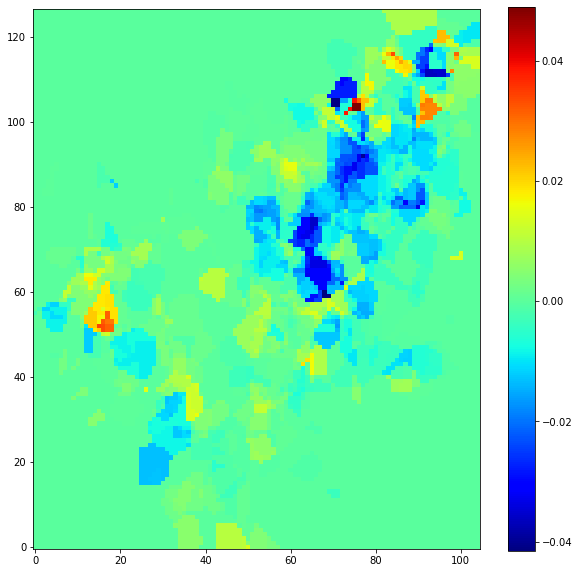

In [36]:
plt.figure(figsize=(10,10))
plt.imshow(vel3d[2,:,:].T,cmap='jet')
plt.gca().invert_yaxis()
plt.colorbar()